<a href="https://www.kaggle.com/code/gianpieroandrenacci/credit-card-customer-churn-classification?scriptVersionId=195811620" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<h1 style="background-color:#002b80;font-family:serif;font-size:350%;color: #fff;text-align:center;border-radius: 50px 50px;">Credit Card Customer Churn</h1>


* [1. Introduction](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Custom Functions](#1.2)
    * [1.3 Load the Data](#1.3)
    * [1.4 Dataset Description](#1.4)
* [2. Data Munging](#2)
    * [2.1 Data Munging](#2.1)
    * [2.2 Eda (Exploratory Data Analysis)](#2.2)
* [3. Data Preprocessing](#3)
    * [3.1 Data Upsampling Using SMOTE](#3.1)
    * [3.2 Principal Component Analysis Of One Hot Encoded Data](#3.2)  
* [4. Model Selection And Evaluation](#4) 
    * [4.1 Cross Validation](#4.1)
    * [4.2 Model Evaluation](#4.2)
    * [4.3 Model Evaluation On Original Data (Before Upsampling)](#4.3)
* [5. Results](#5) 


![](https://datainnovation.org/wp-content/uploads/2022/03/credit-cards.jpg)

<a id="1"></a>
<h1 style="background-color:#002b80;font-family:Serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Introduction</h1>

<div class="alert alert-block alert alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em; ">
    📌 &nbsp; Please keep in mind that we are always on our learning journey. I just want to share something that will be interesting for you. If you find this notebook useful in anyway, please upvote it so that it can reach a bigger audience. You can share it with your fellow kagglers. 
</div>

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">A manager at the bank is disturbed with more and more customers leaving their credit card services. They would really appreciate if one could predict for them who is gonna get churned so they can proactively go to the customer to provide them better services and turn customers' decisions in the opposite direction</p>

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">The dataset consists of 10,000 customers mentioning their age, salary, marital_status, credit card limit, credit card category, etc. There are nearly 18 features.
The dataset name  is Credit Card customers and it is stored on Kaggle.
</p>

<a id="1.1"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Libraries and utilities</h1>

In [36]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from numpy import log
from datetime import date
import seaborn as sns # For creating plots
import matplotlib.ticker as mtick # For specifying the axes tick format 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns


from numpy import mean
from numpy import std
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
    
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.set(style = 'white')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

        
        

/kaggle/input/credit-card-customers/BankChurners.csv


<a id="1.2"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Custom Functions</h1>

In [37]:
def bar_plot(df,ax, column_name= None,xlabel= None, ylabel= None, title= None,colors = ['#042370','#D63F1D'], reorderlist = None):
    """
    Python function to plot a specific column of dataframe
    df: dataframe
    colum_name: column to plot
    xlabel:  y axis label
    ylabel:  y axis label
    colors: colors of the bars
    """
    #colors
    colors = colors
    
    #percentage of total
    df = df[column_name].value_counts()*100.0 /len(df)
     #reorder
    if reorderlist is not None:
        df = df.reindex(reorderlist)
    
    #group by column and count 
    df.plot(ax= ax,kind='bar',
             stacked = True,
             rot = 0,
             color = colors,
             #figsize = (15,8)
           )
    #format axis and labels
    #ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.yaxis.set_visible(False)
    ax.set_ylabel(ylabel,size = 14)
    ax.set_xlabel(xlabel,size = 14)
    ax.set_title(title, size = 14)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())

    # set individual bar lables using above list
    total = sum(totals)

    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_x()+.10, i.get_height()-8.0, str(round((i.get_height()/total), 1))+'%',\
                fontsize=16,
                color='white',
                weight = 'bold',
                )

    return 

###############################################################


def bar_plot_tot(df, ax, column_name= None,xlabel= None, ylabel= None, title= None,colors = ['#042370','#D63F1D'],reorderlist = None):
    """
    Python function to plot a specific column of dataframe
    df: dataframe
    colum_name: column to plot
    xlabel:  y axis label
    ylabel:  y axis label
    colors: colors of the bars
    """
    #colors
    colors = colors
    #totald
    df = df[column_name].value_counts()
     #reorder
    if reorderlist is not None:
        df = df.reindex(reorderlist)
    
    #group by column and count 
    df.plot.barh(ax= ax,
                 stacked = True,
                 rot = 0,
                 color = colors,
                # figsize = (15,8)
                )
    #format axis and labels
   # ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    ax.set_ylabel(ylabel,size = 14)
    ax.set_xlabel(xlabel,size = 14)
    ax.set_title(title, size = 14)
    
    ax.xaxis.set_visible(False)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(True)
    
    # create a list to collect the plt.patches data
    totals = []

    # find the values and append to list
    for i in ax.patches:
        totals.append(i.get_width())
    for i, v in enumerate(totals):
        ax.text(v/2-(v/3), i, str(int(v)), color='white', fontweight='bold', fontsize=16, ha='left', va='center')
    
  
    return 


########################################

def bar_stacked_plot(df, ax, label= None, feature= None, title= None,colors = ['#042370','#D63F1D'],reorderlist = None):
    """
    Python function to plot a stacked bar plot based on feature/label aggregation count
    df: dataframe
    label : label of dataframe
    feature: feature of dataframe
    title:  plot title
    colors: colors of the bars
    reorderlist: specify order if ordinal
    """
    #bar colors
    colors = colors
    
    #group by label and feature and count the feature
    df = df.groupby([feature,label]).size().unstack()
    #reorder
    if reorderlist is not None:
        df = df.reindex(reorderlist)
        
    # stacked bar plot
    (df.T*100.0 / df.T.sum()).T.plot(   kind='bar',
                                                    ax = ax,
                                                    width = 0.5,
                                                    stacked = True,
                                                    rot = 0, 
                                                    #figsize = (18,8),
                                                    color = colors
                                                     )
    #set font
    csfont = {'fontname':'sans-serif'}
    #set axis param , title, labels
    ax.yaxis.set_visible(False)
    ax.set_ylabel('% ' + feature,size = 14,**csfont)
    ax.set_xlabel('')
    ax.legend( loc='center left', bbox_to_anchor =(1,0.5),prop={'size':14},title = label)
    ax.set_title(title,size = 14,**csfont)
          
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Code to add the data labels on the stacked bar chart
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.annotate('{:.0f}%'.format(height), (p.get_x()+.2*width, p.get_y()+.4*height),
                    color = 'white',
                   weight = 'bold',
                   size = 14)

    return


########################################

def dist_plot_kde(df, ax, label, feature ,xlabel= None,  title= None):
    """
    Python function to plot the distribution of a feature for positive or negative label values
    df: dataframe
    ax: plot definition 
    label: label
    feature: feature
    title: title of the plot
    xlabel:  x axis label
    
    """
    #positive label
    ax = sns.kdeplot(cust_df[feature].loc[(cust_df[label] == 1)],
                     color="Red", shade = True)
    #negative label
    ax = sns.kdeplot(cust_df[feature].loc[(cust_df[label] == 0)],
                     ax =ax, color="Blue", shade= True, alpha= 0.2)
    
    #legend and other plot labels
    ax.legend([label,"Not " + label ],loc='upper right')
    ax.set_ylabel('Density')
    ax.set_xlabel(xlabel)
    ax.set_title(title)

    return 


########################################

# evaluate a model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    # evaluate model
    scores = cross_val_score(model, X, y, scoring='recall', cv=cv, n_jobs=-1)
    return scores

########################################

# define models to test
def get_models():
    models, names = list(), list()
    # CART
    models.append(DecisionTreeClassifier())
    names.append('CART')
    # SVM
    models.append(SVC(gamma='scale'))
    names.append('SVM')
    # Bagging
    models.append(BaggingClassifier(n_estimators=100))
    names.append('BAG')
    # RF
    models.append(RandomForestClassifier(n_estimators=100))
    names.append('RF')
    # GBM
    models.append(GradientBoostingClassifier(n_estimators=100))
    names.append('GBM')
    #LightGBM
    models.append(LGBMClassifier())
    names.append('LightGBM')
    # LR
    # models.append(LogisticRegression())
    # names.append('LR')
    return models, names

<a id="1.3"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Load the Data</h1>

In [38]:
#load the dataset from csv file
cust_df = pd.read_csv('/kaggle/input/credit-card-customers/BankChurners.csv')

# PLEASE IGNORE THE LAST 2 COLUMNS (NAIVE BAYES CLAS…). I SUGGEST TO RATHER DELETE IT BEFORE DOING ANYTHING**
cust_df = cust_df.iloc[:,:-2]

#drop also the customer number
cust_df.drop(columns =["CLIENTNUM"] , inplace = True)

cust_df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


<a id="1.4"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Dataset Description</h1>

* CLIENTNUM > Client number, Unique identifier for the customer holding the account.
* Attrition_Flag > Internal event (customer activity) variable - if the account is closed then 1 else 0.
* Customer_Age > Demographic variable - Customer’s Age in Years.
* Gender > Demographic variable - M=Male, F=Female.
* Dependent_count > Demographic variable - Number of dependents.  Number of dependents a user has. That is, how many people are dependent on a credit card user for financial support. A higher count tells us that the expenditures can be high.
* Education_Level > Demographic variable - Educational Qualification of the account holder (example: high school, college graduate, etc.).
* Marital_Status > Demographic variable - Married, Single, Divorced, Unknown
* Income_Category > Demographic variable - Annual Income Category of the account holder
* Card_Category > Product Variable - Type of Card (Blue, Silver, Gold, Platinum).
* Months_on_book > Period of relationship with bank.
* Total_Relationship_Count > Total no. of products held by the customer.
* Months_Inactive_12_mon > No. of months inactive in the last 12 months.
* Contacts_Count_12_mon > No. of Contacts in the last 12 months.
* Credit_Limit > Credit Limit on the Credit Card.
* Total_Revolving_Bal > With revolving credit, a consumer has a line of credit he can keep using and repaying over and over. The balance that carries over from one month to the next is the revolving balance on that loan.
* Avg_Open_To_Buy > Open to Buy Credit Line (Average of last 12 months). 
* Total_Amt_Chng_Q4_Q1 > Change in Transaction Amount (Q4 over Q1).
* Total_Trans_Amt > Total Transaction Amount (Last 12 months).
* Total_Trans_Ct > Total Transaction Count (Last 12 months).
* Total_Ct_Chng_Q4_Q1 > Change in Transaction Count (Q4 over Q1).
* Avg_Utilization_Ratio > Average Card Utilization Ratio.

<a id="2"></a>
<h1 style="background-color:#002b80;font-family:Serif;font-size:300%;color: #fff;text-align:center;border-radius: 50px 50px;">Data Manipulation and Eploration</h1>

<a id="2.1"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Data Munging</h1>

In [39]:
cust_df['Attrition_Flag'].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">This is our label: Churn or not Churn?</p>

In [40]:
# define churn as 1 and 0 (yes or no)
cust_df["Churn"] = np.where(cust_df["Attrition_Flag"] == "Attrited Customer", 1, 0)

#remove Attrition_Flag
cust_df.drop(columns=["Attrition_Flag"],inplace = True)

In [41]:
#check null values
cust_df.isnull().sum()

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
Churn                       0
dtype: int64

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">We are lucky! There are no nulls</p>

In [42]:
# let's check Income Category
cust_df['Income_Category'].unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [43]:
# replace the unknown incomes with the mode of the Income_Category
cust_df['Income_Category'].replace('Unknown', cust_df['Income_Category'].mode()[0], inplace=True)


<a id="2.2"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">EDA (Exploratory Data Analysis)</h1>

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> % Customer Churn</p>

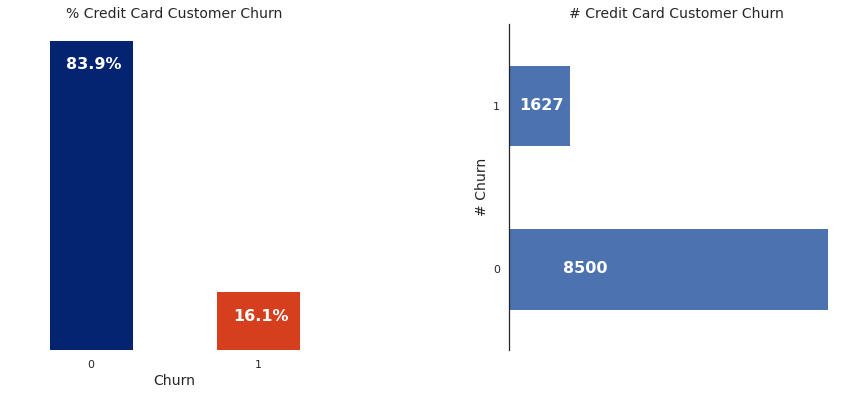

In [44]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(15)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_plot(cust_df,ax1,column_name= "Churn",xlabel= "Churn", ylabel= "% Churn Rate", title= "% Credit Card Customer Churn")

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= "Churn",xlabel= "Churn", ylabel= "# Churn", title= "# Credit Card Customer Churn",colors = 'b')

<p style="font-size:130%; font-weight: bold; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">We have  16.1% of customers who have churned. Thus, it's a bit difficult to train our model to predict churning customers. It is an imbalanced data set.
</p>  

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif"> 
</p>  

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Income Category</p>

In [45]:
def bar_stacked_plot(df, ax, label=None, feature=None, title=None, colors=['#042370', '#D63F1D'], reorderlist=None):
    """
    Python function to plot a stacked bar plot based on feature/label aggregation count
    df: dataframe
    label : label of dataframe
    feature: feature of dataframe
    title:  plot title
    colors: colors of the bars
    reorderlist: specify order if ordinal
    """
    # Group by label and feature and count the feature
    df = df.groupby([feature, label]).size().unstack()

    # Reorder if needed
    if reorderlist is not None:
        df = df.reindex(reorderlist)

    # Plot the stacked bar chart
    (df.T * 100.0 / df.T.sum()).T.plot(
        kind='bar',
        ax=ax,
        width=0.6,
        stacked=True,
        rot=0,
        color=colors
    )

    # Set font
    csfont = {'fontname': 'sans-serif'}
    
    # Set axis parameters, title, and labels
    ax.yaxis.set_visible(False)
    ax.set_ylabel('% ' + feature, size=14, **csfont)
    ax.set_xlabel('')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 14}, title=label)
    ax.set_title(title, size=14, **csfont)

    # Hide spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    # Add data labels at the center of each bar
    for p in ax.patches:
        width = p.get_width()
        height = p.get_height()
        x = p.get_x()
        y = p.get_y()
        
        # Center the label in the middle of the bar
        ax.annotate(
            '{:.0f}%'.format(height),
            (x + width / 2, y + height / 2),
            ha='center', va='center',
            color='white',
            weight='bold',
            size=14
        )

    return


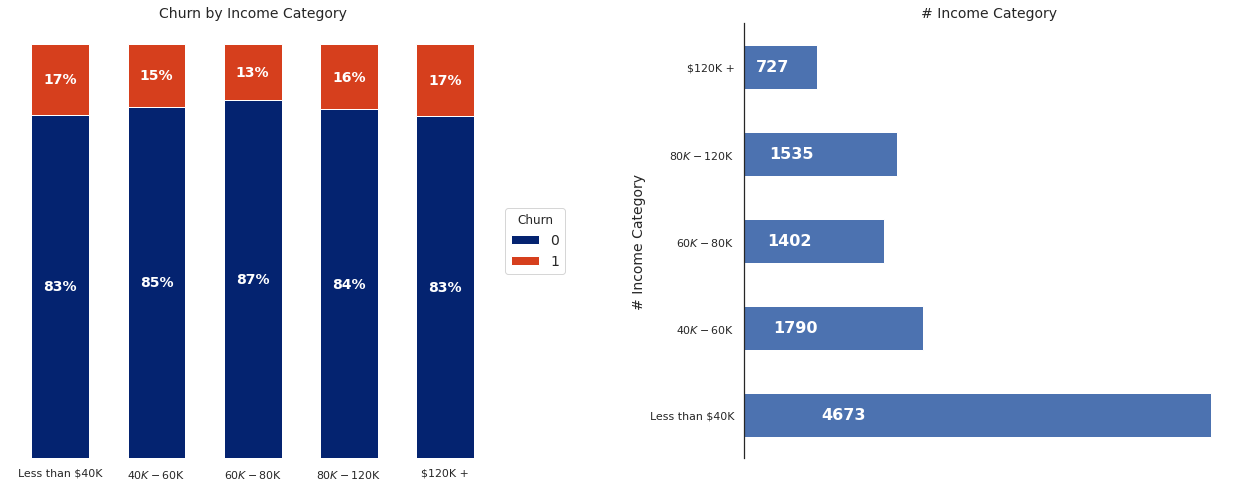

In [46]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(22)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

#reorder category 
reorderlist = ['Less than $40K', '$40K - $60K', '$60K - $80K', '$80K - $120K', '$120K +']

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Income_Category', title= 'Churn by Income Category', reorderlist = reorderlist)

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Income_Category',xlabel= "Income Category", ylabel= "# Income Category", title= "# Income Category",colors=  ['b'] ,reorderlist = reorderlist)

<p style="font-size:120%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">Very low income and very high income tend to churn a little bit more</p>

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Education Level</p>

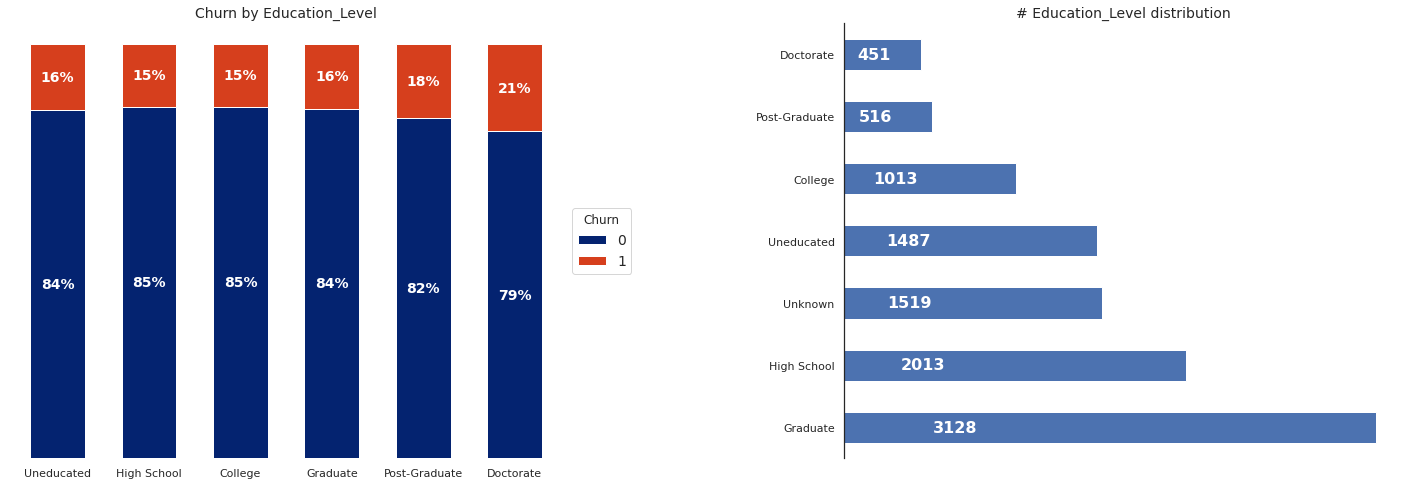

In [47]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(25)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

#reorder the categories
reorderlist =['Uneducated', 'High School', 'College', 'Graduate', 'Post-Graduate', 'Doctorate']

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Education_Level', title= 'Churn by Education_Level', reorderlist = reorderlist)

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Education_Level',  title= "# Education_Level distribution",colors=  ['b'] )

<p style="font-size:120%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">Post-graduate and Doctorate tend to churn a little bit more</p>

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Gender</p>

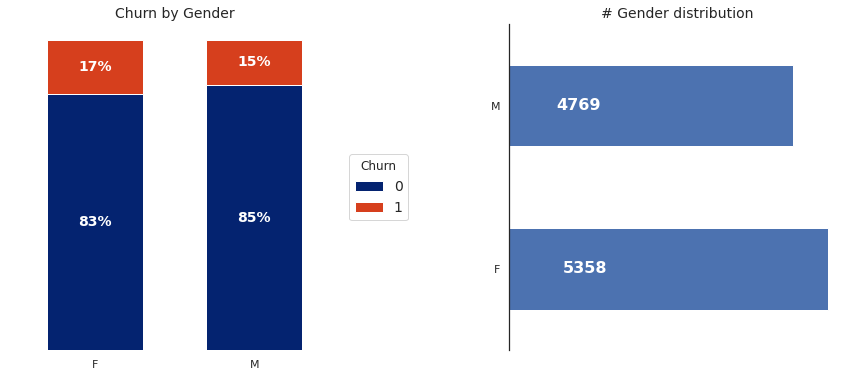

In [48]:
from matplotlib import gridspec
# set figure and size
fig = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(15)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Gender', title= 'Churn by Gender')

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Gender',  title= "# Gender distribution",colors=  ['b'] )

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Card Category</p>

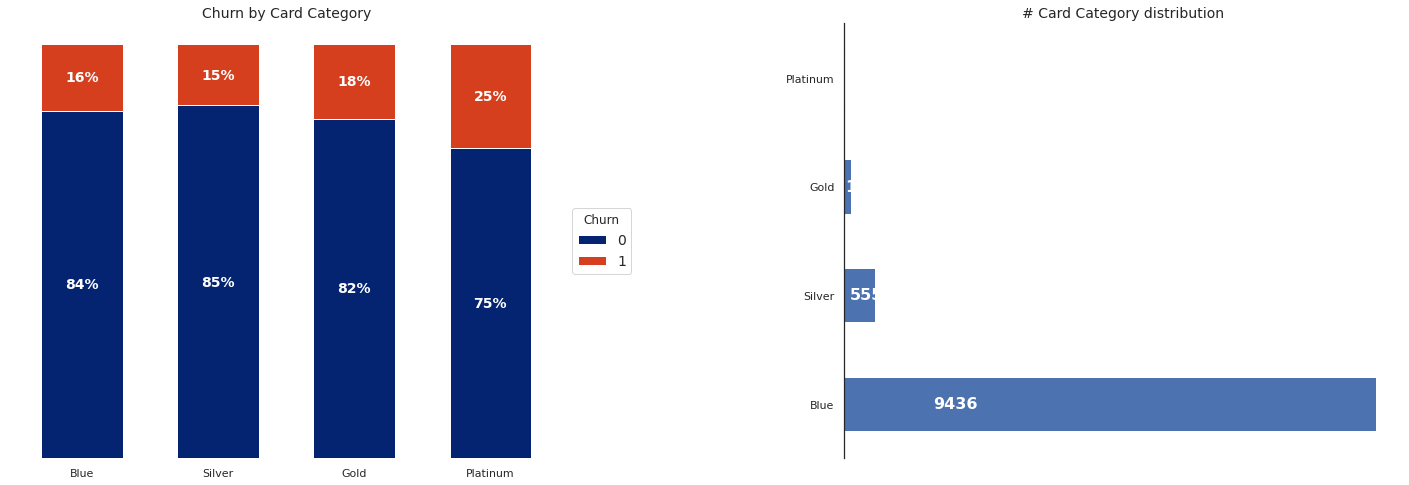

In [49]:
# set figure and size
fig = plt.figure()
fig.set_figheight(8)
fig.set_figwidth(25)

# geometry(Grid we created for subplots),
spec = gridspec.GridSpec(ncols=2, nrows=1,
                         wspace=0.5,
                         hspace=0.5)

#reorder the categories
reorderlist =['Blue', 'Silver', 'Gold', 'Platinum']

# ax1 will take first column
ax1 = fig.add_subplot(spec[0])
bar_stacked_plot(cust_df,ax1 ,label= 'Churn', feature= 'Card_Category', title= 'Churn by Card Category', reorderlist = reorderlist)

# ax2 will take second column
ax2 = fig.add_subplot(spec[1])
bar_plot_tot(cust_df,ax2,column_name= 'Card_Category',  title= "# Card Category distribution",colors=  ['b'] )

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Customer Age</p>

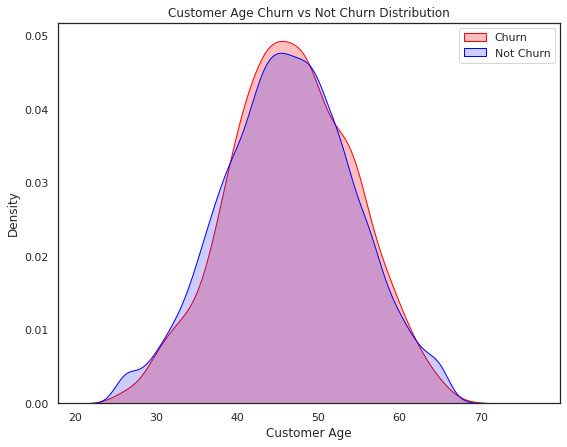

In [50]:
fig, ax = plt.subplots(figsize=(9,7))
dist_plot_kde(df = cust_df,ax = ax,label = 'Churn', feature = "Customer_Age" ,xlabel= 'Customer Age',  title= 'Customer Age Churn vs Not Churn Distribution')

<p style="font-size:120%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">Age has no effect on Churn</p>

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Credit Limit</p>

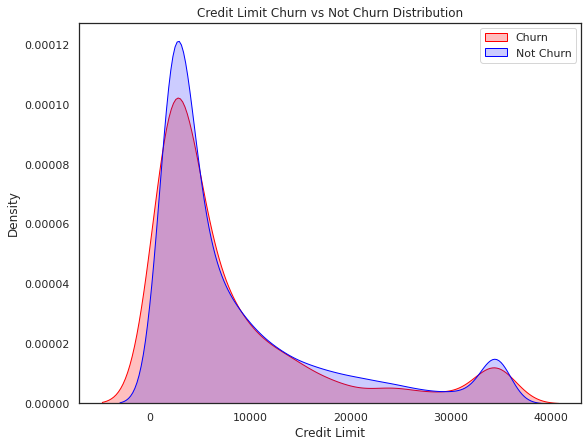

In [51]:
fig, ax = plt.subplots(figsize=(9,7))
dist_plot_kde(df = cust_df,ax = ax,label = 'Churn', feature = "Credit_Limit" ,xlabel= 'Credit Limit',  title= 'Credit Limit Churn vs Not Churn Distribution')

<p style="font-size:120%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">Credit limit has little effect on Churn. There are more customers with low credit limit that do not churn </p>

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Total Transactions Amount</p>

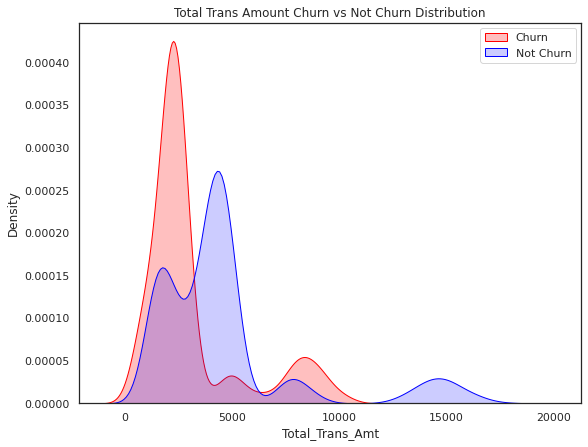

In [52]:
fig, ax = plt.subplots(figsize=(9,7))
dist_plot_kde(df = cust_df,ax = ax,label = 'Churn', feature = "Total_Trans_Amt" ,xlabel= 'Total_Trans_Amt',  title= 'Total Trans Amount Churn vs Not Churn Distribution')

<p style="font-size:120%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif">Total transaction amount has a relevant effect on Churn. Customers with low Total Transactions Amount tend to churn more</p>

<p style="font-size:150%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> CORRELATION MATRIX</p>

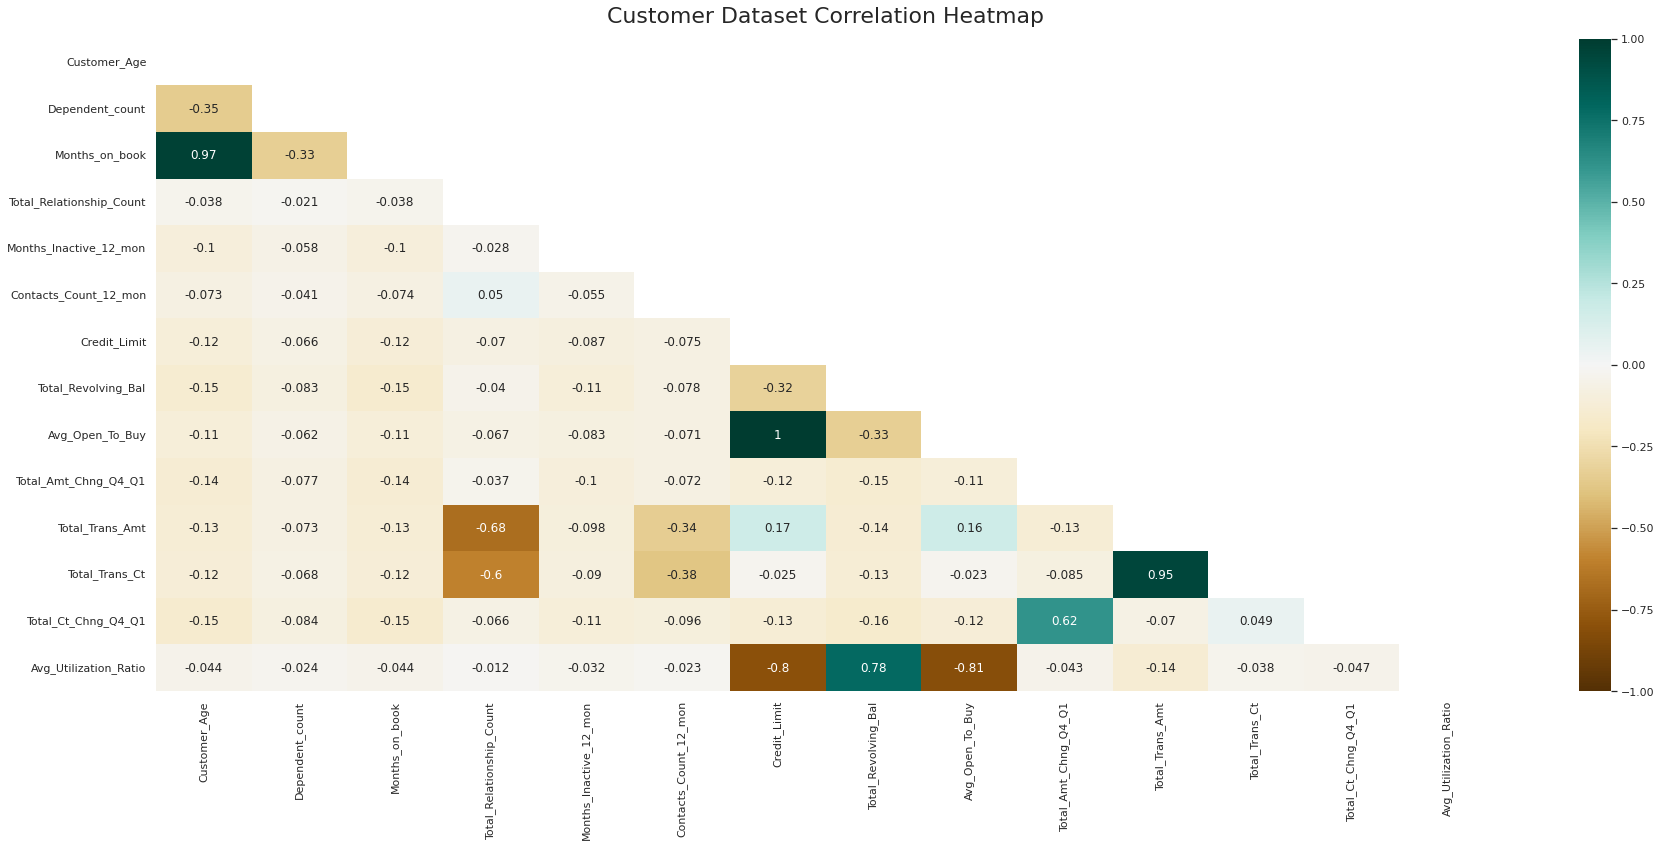

In [53]:
#slect numerical feature and exlude the label
num_data = cust_df.select_dtypes(exclude=['object'])
df_corr_matrix = num_data.iloc[:,:-1].corr()

#if correlation is low put 0 (for correlation matrix redability)
df_corr_matrix[abs(df_corr_matrix) < 0.1] = 0 

#plot the correlation matrix
plt.figure(figsize=(30, 12))

# define the mask to set the values in the upper triangle to True
mask = np.triu(np.ones_like(df_corr_matrix.corr(), dtype=np.bool_))
heatmap = sns.heatmap(df_corr_matrix.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Customer Dataset Correlation Heatmap', fontdict={'fontsize':22}, pad=16);

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Considerations</p>

* Customer age and Months on book have a high correlation because younger customers just got the possibility of getting a credit card thing
* Avg_Open_To_Buy and Credit_Limit have a high correlation because they are telling the same thing
* Total Transaction Amount is high correlated with Total Transacion Count because usually the amount tends to get higher as the count of transactions grow

The features 'Credit_Limit', 'Total_Revolving_Bal','Avg_Open_To_Buy','Total_Ct_Chng_Q4_Q1','Months_on_book', 'Total_Trans_Ct'

**could be eliminated** beacuse of high correlation with other features feature.

I've tried to eliminate them, but the models performance are not as good as with all the features. **The kind of models that we are going to use are not affected by multicollinearity**.
Infact highly correlated variables won't cause multi-collinearity issues in random forest models.

<a id="4"></a>
<h1 style="background-color:#002b80;font-family:Serif;font-size:300%;color: #fff;text-align:center;border-radius: 50px 50px;">Model selection and evaluation</h1>

<a id="4.1"></a>
<h1 style="background-color:#002b80;font-family:serif;font-size:250%;color: #fff;text-align:center;border-radius: 50px 50px;">Test different models performance</h1>

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Encode and Split</p>

In [54]:
# divide features and label , encode label
y = cust_df['Churn'].values
X = cust_df.drop(columns = ['Churn'])
#y = LabelEncoder().fit_transform(y)

#categorical and numerical 
cat_ix = X.select_dtypes(include=['object', 'bool']).columns
num_ix = X.select_dtypes(include=['int64', 'float64']).columns


# define models
models, names = get_models()
results = list()

#define pipeline for categorical transformer 
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

#split train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold"> Build the Pipeline</p>

How to deal with imbalance data. Perform over-sampling using SMOTE.

This object is an implementation of SMOTE - Synthetic Minority Over-sampling Technique as presented in 

>CART 0.827 (0.040)
>SVM 0.804 (0.027)
>BAG 0.876 (0.031)
>RF 0.850 (0.036)
>GBM 0.896 (0.023)
>LightGBM 0.910 (0.024)


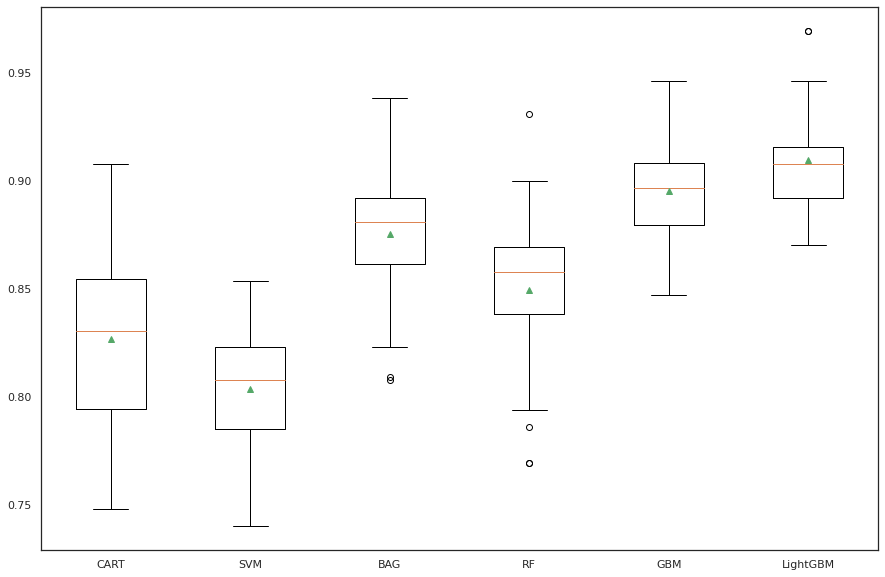

In [55]:
# evaluate each models

#smote for oversampling
smt = SMOTE(random_state=42)

for i in range(len(models)):
    # define steps
    steps = [('c',categorical_transformer,cat_ix), ('n',MinMaxScaler(),num_ix)]
    # one hot encode categorical, normalize numerical
    ct = ColumnTransformer(steps)
    # wrap the model i a pipeline
    pipeline = imbpipeline(steps=[('t',ct),('smt', smt),('m',models[i])])
    # evaluate the model and store results
    scores = evaluate_model(X_train, y_train, pipeline)
    results.append(scores)
    # summarize performance
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))
    
# plot the results
plt.figure(figsize=(15, 10))
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">The best model is LightGBM</p>

**LightGBM** is a gradient boosting framework (**implemented by Microsoft**) that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.
* Lower memory usage.
* Better accuracy.
* Support of parallel, distributed, and GPU learning.
* Capable of handling large-scale data.

[Lightgbm](https://lightgbm.readthedocs.io/en/v3.3.2/)

<p style="font-size:110%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">Search for the best parameters</p>

In [56]:
# build the parameters grid 

param_grid = \
[
    {  
    "m__learning_rate":[0.1, 0.5],
    "m__max_depth":[30],
    "m__num_leaves":[10,100],
    "m__feature_fraction":[0.1,1.0],
    "m__subsample":[0.1,1.0],
    }
]
param_grid

[{'m__learning_rate': [0.1, 0.5],
  'm__max_depth': [30],
  'm__num_leaves': [10, 100],
  'm__feature_fraction': [0.1, 1.0],
  'm__subsample': [0.1, 1.0]}]

In [57]:
# define the location of the dataset
import warnings
warnings.filterwarnings("ignore")


smt = SMOTE(random_state=42)

#BGC = BaggingClassifier()
CLS = LGBMClassifier()

# define steps
steps = [('c',categorical_transformer,cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model i a pipeline
pipeline = imbpipeline(steps=[('t',ct),('smt',smt),('m',CLS)])
# evaluate the model and store results
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                       scoring='recall',
                       return_train_score=True,n_jobs = -1, refit=True)

grid_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('t',
                                        ColumnTransformer(transformers=[('c',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='constant')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['Gender', 'Education_Level', 'Marital_Status', 'Income_Category',
       'Card_Category'],
      dtype='object')),
                                                                        ('n

In [58]:
import numpy as np
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)


0.7696168582375478 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 0.1}
0.7696168582375478 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 1.0}
0.6974241084585913 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 100, 'm__subsample': 0.1}
0.6974241084585913 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.1, 'm__max_depth': 30, 'm__num_leaves': 100, 'm__subsample': 1.0}
0.8425699970527557 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.5, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 0.1}
0.8425699970527557 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.5, 'm__max_depth': 30, 'm__num_leaves': 10, 'm__subsample': 1.0}
0.7696492779251399 {'m__feature_fraction': 0.1, 'm__learning_rate': 0.5, 'm__max_depth': 30, 'm__num_leaves': 100, 'm__subsample': 0.1}
0.7696492779251399 {'m__feature_fraction': 0.1, 'm__

<p style="font-size:130%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">The best parameters are:</p>

In [59]:
print(grid_search.best_score_)
grid_search.best_params_


0.9047627468317124


{'m__feature_fraction': 1.0,
 'm__learning_rate': 0.5,
 'm__max_depth': 30,
 'm__num_leaves': 10,
 'm__subsample': 0.1}

<p style="font-size:130%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">Test final model</p> 

In [60]:
name = "LGBMClassifier"
smt = SMOTE(random_state=42)


CLS = LGBMClassifier(feature_fraction = 1.0,learning_rate=0.5,
                         max_depth= 30,num_leaves= 10,subsample= 0.1)

# define steps
steps = [('c',categorical_transformer,cat_ix), ('n',MinMaxScaler(),num_ix)]
# one hot encode categorical, normalize numerical
ct = ColumnTransformer(steps)
# wrap the model i a pipeline
pipeline = imbpipeline(steps=[('t',ct),('smt',smt),('m',CLS)])
# evaluate the model and store results
pipeline.fit(X_train, y_train)
#predict
preds = pipeline.predict(X_test)
preds

array([0, 0, 0, ..., 1, 0, 0])

<p style="font-size:130%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">Evaluate the model</p> 

In [61]:
#evaluate final model
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import lightgbm as ltb
# Print the prediction accuracy
pred_accuracy = metrics.accuracy_score(y_test, preds)
pred_recall = metrics.recall_score (y_test, preds)
pred_precision = metrics.precision_score (y_test, preds)

print('Accuracy: ' f"{pred_accuracy:,.4%}")
print('Recall: ' f"{pred_recall:,.4%}")
print('Precision: ' f"{pred_precision:,.4%}")

confusion_matrix(y_test,preds)

Accuracy: 96.8411%
Recall: 88.3077%
Precision: 91.6933%


array([[1675,   26],
       [  38,  287]])

<p style="font-size:130%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">Confusion Matrix</p> 

Text(48.5, 0.5, 'Actual classes')

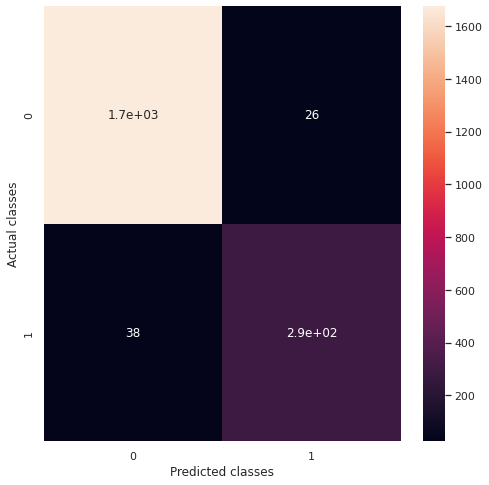

In [62]:
cfm = confusion_matrix(y_test, preds)
plt.figure(figsize=(8,8))
sns.heatmap(cfm, annot=True)

plt.xlabel('Predicted classes')
plt.ylabel('Actual classes')

<p style="font-size:130%; background-color:#F8F9F9;border-radius: 0px 30px;text-align:center;font-family:Sans-serif;font-weight:bold">Features importance</p> 

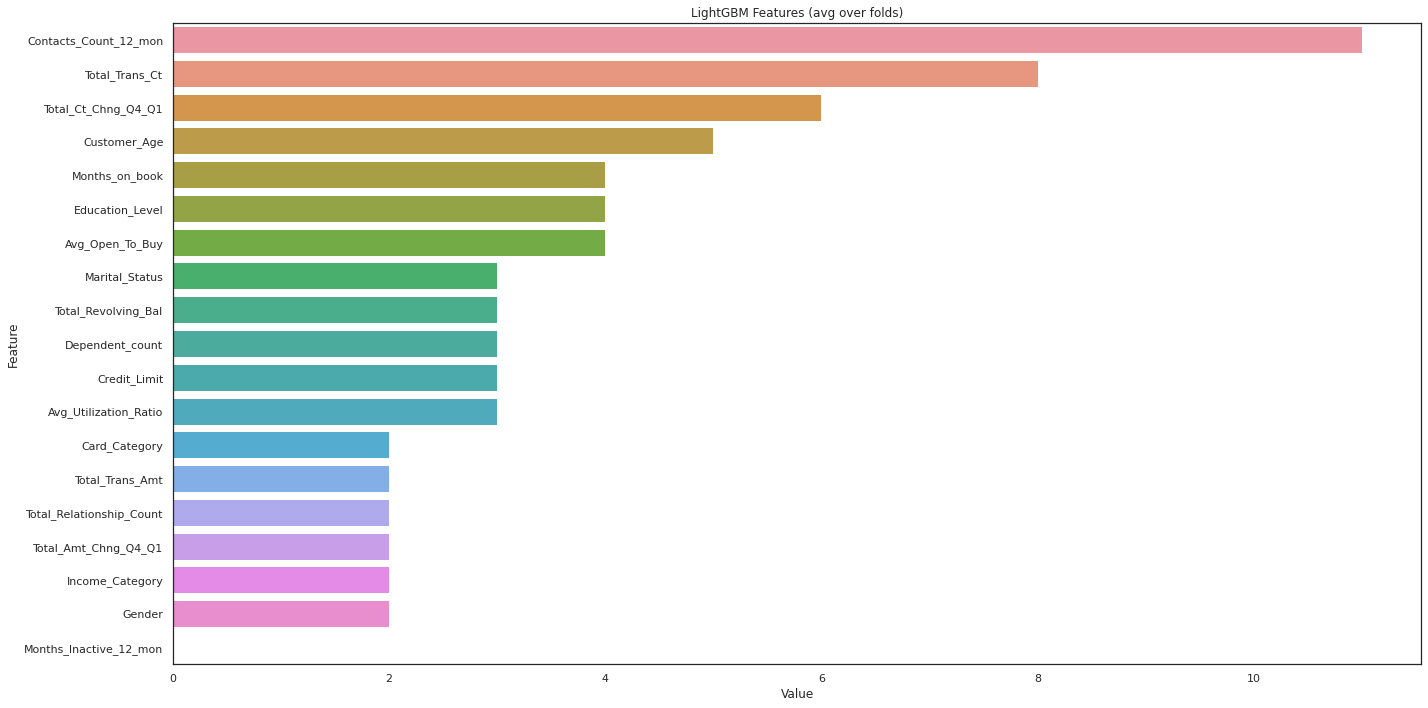

[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGBM] [Warning] feature_fraction is set=0.1, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1
[LightGB

In [63]:

feature_imp = pd.DataFrame(sorted(zip(CLS.feature_importances_,X.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
